# Планирования штата в компании

Компания нуждается в помощи для поиска оптимального количества персонала, необходимого для обработки поступающих заявок. В данной сфере численность персонала считается непрерывной переменной. Этот показатель также называется эквивалентом полной занятости (ЭПЗ) персонала.

Компания работает в трех городах : A, B и C.

Компания может либо обрабатывать заявки с помощью нанятого персонала, либо передать его на аутсорсинг. Предположим, что для аутсорсинга нет ограничений по мощности.

Если они нанимают человека в штат, он может обрабатывать 30 страховых заявлений в месяц, когда он работает 100% рабочих дней. Однако бывают дни, когда он/она будет недоступен для обработки заявок из-за обучения, выходных. Также может быть, что не удается набрать нужное количество персонала в штат.

В округах A и B существует нормативное ограничение, согласно которому заявки на страхование на аутсорсинге не могут превышать 30% и 40% от общего количества заявок за каждый месяц соответственно.

Цель состоит в том, чтобы оптимизировать общую стоимость процесса утверждения заявок путем распределения нужного количества заявок между людьми в штате и аутсорсингом, одновременно удовлетворяя ежемесячный спрос для каждого города/области.


In [ ]:
# использовался GNU Linear Programming Kit solver, тк модель несложная и производительности glpk вполне хватит

!pip install -q pyomo
!apt-get install -y -qq coinor-cbc
!apt-get install -y -qq glpk-utils
!pip install -q openpyxl

     |████████████████████████████████| 9.6 MB 27.6 MB/s 
     |████████████████████████████████| 49 kB 7.5 MB/s 
Selecting previously unselected package coinor-libcoinutils3v5.
(Reading database ... 155639 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.10.14+repack1-1_amd64.deb ...
Unpacking coinor-libcoinutils3v5 (2.10.14+repack1-1) ...
Selecting previously unselected package coinor-libosi1v5.
Preparing to unpack .../1-coinor-libosi1v5_0.107.9+repack1-1_amd64.deb ...
Unpacking coinor-libosi1v5 (0.107.9+repack1-1) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.16.11+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.16.11+repack1-1) ...
Selecting previously unselected package coinor-libcgl1.
Preparing to unpack .../3-coinor-libcgl1_0.59.10+repack1-1_amd64.deb ...
Unpacking coinor-libcgl1 (0.59.10+repack1-1) ...
Selecting previously unselected package coinor-libcbc3.
Preparing to un

In [ ]:
from __future__ import division
from pyomo.environ import *
from pyomo.opt import SolverFactory

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

Компания хочет, чтобы вы помогли ей найти оптимальное количество сотрудников, необходимое им для процесса утверждения заявки на страхование. В данной индустрии численность персонала считается непрерывной переменной. Это также называется эквивалентом полной занятости (ЭПЗ) персонала. Например, если штатный сотрудник (ЭПЗ = 1) работает 50 часов в неделю, 10 часов соответствуют 0,2 ЭПЗ. Если оплата за 50 часов в неделю составляет 5000 долларов, то 0,2 ЭПЗ, которые могут быть работниками, работающими неполный рабочий день, будут получать 1000 (5000*0,2).

In [ ]:

#Датафрейм для информации о персонале в штате
StaffAvailability = pd.read_excel("/Штат.xlsx", sheet_name ='StaffAvailability')


In [ ]:

# доступность персонала в штат LB - худший сценарий, UB - лучший сценарий, StaffAvPer
StaffAvailability.head(10)

,State,Month,LB,UB,StaffAvPer
0,A,Jan,0.70,0.90,0.81
1,A,Feb,0.65,0.85,0.76
2,A,Mar,0.70,0.80,0.75
3,A,Apr,0.75,0.85,0.80
4,A,May,0.70,0.85,0.78
5,A,Jun,0.65,0.80,0.73
6,A,Jul,0.60,0.75,0.68
7,A,Aug,0.65,0.85,0.76
8,A,Sep,0.70,0.90,0.81
9,A,Oct,0.65,0.80,0.73


In [ ]:

#Таблица стоимости персонала
cost = pd.read_excel("/Штат.xlsx", sheet_name ='Cost')

#Кол-во обрабатывааемых заявок одним сотрудником
ServiceRate = pd.read_excel("/Штат.xlsx", sheet_name ='ServiceRate')

#Спрос на персонал. Кол-во необходимых ЭПЗ в месяц
DemandData = pd.read_excel("/Штат.xlsx", sheet_name ='DemandData')


In [ ]:
# стоимость персонала в денежных единицах

cost.head()

,State,Month,AnnualSalary,MonthlySalary,UnitOutSourceCost
0,A,Jan,600000,50000.0,1800
1,A,Feb,600000,50000.0,1800
2,A,Mar,600000,50000.0,1800
3,A,Apr,600000,50000.0,1800
4,A,May,600000,50000.0,1800


In [ ]:
#норматив обрабатываемых заявок для сотрудников в штате

ServiceRate.head()

,MgAppServedPerMonth
0,60


In [ ]:
#необходимо обработать заявок

DemandData.head()

,State,Month,Demand
0,A,Jan,5240
1,A,Feb,4878
2,A,Mar,5942
3,A,Apr,2297
4,A,May,1992


## Подготовка данных

In [ ]:
# Создаем словари с ключем месяц и город и соответсвующим значением

# "ЭПЗ" -  эквивалент полной штатной единицы; пересчёт на полную ставку (представление численности персонала путём
# деления совокупного рабочего времени всех сотрудников на рабочее время полностью занятого работника 

# Demand необходимо обработать заявок в данном месяце
Demand = DemandData.set_index(['State','Month'])['Demand'].to_dict()

# Создаем справочник зарплат в Штате
FTE_Salary = cost.set_index(['State','Month'])['MonthlySalary'].to_dict()

# Cоздаем справочник стоимость аутсорса
UnitOutSourceCost = cost.set_index(['State','Month'])['UnitOutSourceCost'].to_dict()

FTE_AppServRate = 30

#обычный сценарий доступности штата
StaffAvailability_StaffAvPer = StaffAvailability.set_index(['State','Month'])['StaffAvPer'].to_dict()
#худщий сценарий
StaffAvailability_StaffAv_LB = StaffAvailability.set_index(['State','Month'])['LB'].to_dict()
#лучший сценарий
StaffAvailability_StaffAv_UB = StaffAvailability.set_index(['State','Month'])['UB'].to_dict()

State = cost['State'].unique()

Month = cost['Month'].unique()

Decision Variable:

> ${FTE}_{S,M} \,\,\,\,\,\,\, \text{где} \ S \in State \ M \in Month $<br>

> ${O}_{S,M} \,\,\,\,\,\,\, \text{где} \ S \in State \ M \in Month $<br>


Целевая функция : минимизируем затраты на штатных сотрудников и аутсорс

> $\textrm{min} \sum \limits _{S,M} \text{FTE}_{S,M}* \text{FTE_Salary}_{S,M}$ $\text{+}$ $\text{O}_{S,M}* \text{O_Salary}_{S,M}$


Констрейнты:

Количество заявок необходимых для обработки :
>  $\text{total_demand}_{S,M}\ \text{==}\ \ \text{FTE}_{S,M}*30*\text{Staff availibity
}_{S,M}+\text{O}_{S,M} \ \ \ \ \forall {S \in State} \ {M \in Month}$


>  $\text{O}_{S,M}\leq\text{total_demand}_{S,M}*0.30\ \ \ \ \forall {S \in State A}$

>  $\text{O}_{S,M}\leq\text{total_demand}_{S,M}*0.40\ \ \ \ \forall {S \in State B}$


In [ ]:
# Создаем инстанс модели
model = ConcreteModel()

In [ ]:
# задание sets и Parameters
model.S = Set(initialize=State.tolist(),doc='Города')
model.M = Set(initialize=Month.tolist(),doc='Месяца')
model.demand = Param(model.S,model.M,initialize = Demand,doc='Спрос на персонал')
model.staffavailiability = Param(model.S,model.M,initialize = StaffAvailability_StaffAvPer,doc = 'StaffAvailability_StaffAvPercent')

model.S.pprint()
model.demand.pprint()
model.staffavailiability.pprint()

In [ ]:
# Decision variables
model.F = Var(model.S,model.M,doc='Кол-во. ЭПЗ',domain = NonNegativeReals)  # задаем кол-во эквивалентов полной занятости (1 эквивалент = 30 заявкам)
model.O = Var(model.S,model.M,doc='No of Outsource App',domain = NonNegativeIntegers) # задаем кол-во заявок на аутсорс

In [ ]:
#model.F.pprint()
model.F.pprint()

In [ ]:
# Ограничения

# Создаем условие на спрос (ЭПЗ*30 заявок * доступность_персонала+кол-во заявок на аутсорс == спросу)
def total_demand(m,S,M):
    return (m.F[S,M]*30*m.staffavailiability[S,M] + m.O[S,M] == m.demand[S,M])
            
model.total_demand = Constraint(model.S,model.M, rule=total_demand)

# Для каждого месяца и города устанваливаем на аутсорсинг
model.outsource_demand = ConstraintList()
for M in model.M:
    for S in model.S:
        if S == 'A':                                                                                                                                          
            model.outsource_demand.add(expr = model.O[S,M] <= 0.3*model.demand[S,M])
        elif S == 'B':
            model.outsource_demand.add(expr = model.O[S,M] <= 0.4*model.demand[S,M])

In [ ]:
model.outsource_demand.pprint()

In [ ]:
# Целевая функци : по каждому месяцу и году минимизируем затраты
expr = sum(sum(model.F[S,M]*FTE_Salary[S,M] + model.O[S,M]*UnitOutSourceCost[S,M] for S in model.S) for M in model.M)

model.value = Objective(expr, sense= minimize)

In [ ]:

# Используем солвер

result = SolverFactory('glpk').solve(model, tee=True)
result.write()

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /tmp/tmp717oy8n4.glpk.raw --wglp /tmp/tmpb5rb0xa_.glpk.glp --cpxlp
 /tmp/tmp9f29nr_2.pyomo.lp
Reading problem data from '/tmp/tmp9f29nr_2.pyomo.lp'...
61 rows, 73 columns, 97 non-zeros
36 integer variables, none of which are binary
469 lines were read
Writing problem data to '/tmp/tmpb5rb0xa_.glpk.glp'...
440 lines were written
GLPK Integer Optimizer, v4.65
61 rows, 73 columns, 97 non-zeros
36 integer variables, none of which are binary
Preprocessing...
Objective value =   2.167952346e+08
INTEGER OPTIMAL SOLUTION FOUND BY MIP PREPROCESSOR
Time used:   0.0 secs
Memory used: 0.1 Mb (72516 bytes)
Writing MIP solution to '/tmp/tmp717oy8n4.glpk.raw'...
143 lines were written
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# -------------------------------------------------

In [ ]:

optimized_cost = round(model.value()/1000000,2)

print("\n\n Компания потратит примерно {}m Р на штат рассмотра заявок." .format(optimized_cost))




 Компания потратит примерно 216.8m Р на штат рассмотра заявок.


In [ ]:
# Выводим результаты в таблицу

Output_actual = []


for S in model.S:
    for M in model.M:
        
        # Подсчет общих затрат
        no_of_fte=model.F[S,M].value
        demand = model.demand[S,M]
        no_of_outsource_app = model.O[S,M].value
        no_of_FTE_processed_app = model.F[S,M].value*30*model.staffavailiability[S,M]
        cost = model.F[S,M].value*FTE_Salary[S,M] + model.O[S,M].value*UnitOutSourceCost[S,M]
        percent_outsourced_app = round((no_of_outsource_app/demand)*100,2)
        avg_cost_per_app = round(cost/demand,2)
        
        Output_actual.append([S,M, no_of_fte,demand, no_of_outsource_app,no_of_FTE_processed_app, cost, percent_outsourced_app,avg_cost_per_app])


In [ ]:
        
Output_actual = pd.DataFrame(Output_actual, columns = ['Город', 'Месяц', 'Кол-во ЭПЗ','Спрос','Колво аутсорсных заявок','Кол-во обработанных заявок' ,\
                                                       'Расчетная стоимость', 'Percent outsourced Application', 'Средняя стоимсть обработки заявки в руб'])

Output_actual[['Расчетная стоимость в mn Р']] = Output_actual[['Расчетная стоимость']]/1000000
Output_actual['Спрос'] = Output_actual['Спрос'].astype(int)
Output_actual['Колво аутсорсных заявок'] = Output_actual['Колво аутсорсных заявок'].astype(int)
Output_actual['Кол-во обработанных заявок'] = Output_actual['Кол-во обработанных заявок'].astype(int)
Output_actual = Output_actual.round({"No. of FTE":1, "Колво аутсорсных заявок":0, "Расчетная стоимость в mn Р":1})

In [ ]:
Output_actual

,Город,Месяц,Кол-во ЭПЗ,Спрос,Колво аутсорсных заявок,Кол-во обработанных заявок,Расчетная стоимость,Percent outsourced Application,Средняя стоимсть обработки заявки в руб,Расчетная стоимость в mn Р
0,A,Jan,150.946502,5240,1572,3667,1.037693e+07,30.00,1980.33,10.4
1,A,Feb,149.780702,4878,1463,3415,1.012244e+07,29.99,2075.12,10.1
2,A,Mar,184.888889,5942,1782,4160,1.245204e+07,29.99,2095.60,12.5
3,A,Apr,67.000000,2297,689,1608,4.590200e+06,30.00,1998.35,4.6
4,A,May,59.615385,1992,597,1394,4.055369e+06,29.97,2035.83,4.1
5,A,Jun,72.739726,2275,682,1593,4.864586e+06,29.98,2138.28,4.9
6,A,Jul,183.039216,5334,1600,3734,1.203196e+07,30.00,2255.71,12.0
7,A,Aug,103.508772,3371,1011,2360,6.995239e+06,29.99,2075.12,7.0
8,A,Sep,108.312757,3759,1127,2631,7.444238e+06,29.98,1980.38,7.4
9,A,Oct,112.831050,3529,1058,2471,7.545953e+06,29.98,2138.27,7.5


## Анализ худшего сценария

#### Optimal number of staff members

In [ ]:
model1 = ConcreteModel()

In [ ]:
# Defining Pyomo sets and Parameters
model1.S = Set(initialize=State.tolist(),doc='States')
model1.M = Set(initialize=Month.tolist(),doc='Months')
model1.demand = Param(model1.S,model1.M,initialize = Demand,doc='Demand')
model1.staffavailiability = Param(model1.S,model1.M,initialize = StaffAvailability_StaffAv_LB,doc = 'StaffLowerBoundPercent')

In [ ]:
# Decision variables
model1.F = Var(model1.S,model1.M,doc='No. of FTE',domain = NonNegativeIntegers)  #NonNegativeReals
model1.O = Var(model1.S,model1.M,doc='No of Outsource App',domain = NonNegativeIntegers)

In [ ]:
# Ограничения

# Demand Constraint
def total_demand( m, S, M):
    return (m.F[S,M] * 30 * m.staffavailiability[S,M] + m.O[S,M] == m.demand[S,M])


model1.total_demand = Constraint(model1.S, model1.M, rule=total_demand)

# Outsource Demand Constraints
model1.outsource_demand = ConstraintList()
for M in model1.M:
    for S in model1.S:
        if S == 'A':
            model1.outsource_demand.add(expr = model1.O[S,M] <= 0.3*model1.demand[S,M])
        elif S == 'B':
            model1.outsource_demand.add(expr = model1.O[S,M] <= 0.4*model1.demand[S,M])

In [ ]:
# Целевая функция
model1.value = Objective(expr = sum(sum(model1.F[S,M]*FTE_Salary[S,M]+ model1.O[S,M]*UnitOutSourceCost[S,M] for S in model1.S) for M in model1.M),sense= minimize)

In [ ]:

result = SolverFactory('glpk').solve(model1)
result.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 233234900.0
  Upper bound: 233234900.0
  Number of objectives: 1
  Number of constraints: 61
  Number of variables: 73
  Number of nonzeros: 97
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 1
      Number of created subproblems: 1
  Error rc: 0
  Time: 0.014851093292236328
# ----------------------------------------------------------
#   Solution Information
# ---------------------

In [ ]:
# Printing the value of the objective function
optimized_cost_worst = round(model1.value()/1000000,2)

print("\n\n Компания потратит примерно {}m Р на штат рассмотра заявок с минимальной доступностью персонала." .format(optimized_cost_worst))






 The company has to spend around 233.23m Р in total for the application approval process if the staffs are working with the minimum availability.


In [ ]:
# Creating dataframe for the results
Output_worst = []

for S in model1.S:
    for M in model1.M:
       
        no_of_fte = model1.F[S,M].value
        demand = model1.demand[S,M]
        no_of_outsource_app = model1.O[S,M].value
        no_of_FTE_processed_app = model1.F[S,M].value*30*model1.staffavailiability[S,M]
        cost = model1.F[S,M].value*FTE_Salary[S,M] + model1.O[S,M].value*UnitOutSourceCost[S,M]

        percent_outsourced_app = round((no_of_outsource_app/demand)*100,1)
        avg_cost_per_app = round(cost/demand,1)

        Output_worst.append([S,M, no_of_fte,demand, no_of_outsource_app,no_of_FTE_processed_app, cost, percent_outsourced_app,avg_cost_per_app])
       
    
Output_worst = pd.DataFrame(Output_worst, columns = ['State', 'Month', 'No. of FTE worst','Demand','Колво аутсорсных заявок worst',"No. of FTE Processed Application worst" , 'Расчетная стоимость worst', 'Percent outsourced Application worst', 'average cost per application worst'])

Output_worst['Расчетная стоимость в mn Р worst'] = Output_worst[['Расчетная стоимость worst']]/1000000
Output_worst['Demand'] = Output_worst['Demand'].astype(int)
Output_worst['Колво аутсорсных заявок worst'] = Output_worst['Колво аутсорсных заявок worst'].astype(int)
Output_worst['No. of FTE Processed Application worst'] = Output_worst['No. of FTE Processed Application worst'].astype(int)
Output_worst = Output_worst.round({"No. of FTE worst":1, "Колво аутсорсных заявок worst":0, "Расчетная стоимость в mn Р worst":1})
#Output_worst[['Cost per application worst']] = Output_worst['Расчетная стоимость worst']/Output_worst['Demand']

total_outsourcing =  sum(Output_worst['Колво аутсорсных заявок worst'])
total_cost = sum(Output_worst['Расчетная стоимость worst'])
optimal_staff_members = round(Output_worst['No. of FTE worst'].mean(),1)

total_demand =  sum(Output_worst['Demand'])
average_cost_per_appln = round(total_cost/total_demand,2)
percent_outsourced_app_total = round((total_outsourcing/total_demand)*100,1)
print("Всего заявок на аутсорс: ", total_outsourcing)
print("Общий спрос на колво заявок: ", total_demand)
print("Optimal Staff Members : ", optimal_staff_members)

Total Outsourced Application:  53537
Total Demand Application:  113294
Optimal Staff Members :  84.4


#### Доля заявок отданных на аутсорс

In [ ]:
print("Всего заявок на аутсорс % is : ", percent_outsourced_app_total)

Total Outsourced Application % is :  47.3


#### Average cost per application

In [ ]:
print("Average Cost per Application: ", average_cost_per_appln)

Average Cost per Application:  2058.67


## Best Case Analysis 

#### Optimal number of staff members


In [ ]:
# Creating a model instance
model2 = ConcreteModel()

In [ ]:
# Define Pyomo sets and Parameters
model2.S = Set(initialize=State.tolist(),doc='Город')
model2.M = Set(initialize=Month.tolist(),doc='Месяц')
model2.demand = Param(model2.S,model2.M,initialize = Demand,doc='Спрос')
model2.staffavailiability = Param(model2.S,model2.M,initialize = StaffAvailability_StaffAv_UB,doc = 'StaffUpperBoundPercent')

In [ ]:
# Decision variables
model2.F = Var(model2.S,model2.M,doc='No. of FTE',domain = NonNegativeReals)
model2.O = Var(model2.S,model2.M,doc='No of Outsource App',domain = NonNegativeIntegers)

In [ ]:


# Ограничения на спрос

def total_demand(m, S, M):
    return (m.F[S, M] * 30 * m.staffavailiability[S, M] + m.O[S, M] == m.demand[S, M])


model2.total_demand = Constraint(model2.S, model2.M, rule=total_demand)
#подставляем функцию и сеты в ограничения

# Outsource Demand Constraints
model2.outsource_demand = ConstraintList()
for M in model2.M:
    for S in model2.S:
        if S == 'A':
            model2.outsource_demand.add(expr = model2.O[S,M] <= 0.3*model2.demand[S,M])
        elif S == 'B':
            model2.outsource_demand.add(expr = model2.O[S,M] <= 0.4*model2.demand[S,M])


In [ ]:
# Objective function
model2.value = Objective(expr = sum(sum(model2.F[S,M]*FTE_Salary[S,M]+ model2.O[S,M]*UnitOutSourceCost[S,M] for S in model2.S) for M in model2.M),sense= minimize)

In [ ]:
# Invoking the solver
result = SolverFactory('glpk').solve(model2)
result.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 205446988.306619
  Upper bound: 205446988.306619
  Number of objectives: 1
  Number of constraints: 61
  Number of variables: 73
  Number of nonzeros: 97
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.018528223037719727
# ----------------------------------------------------------
#   Solution Information
# -----------

In [ ]:
# Printing the value of the objective function
optimized_cost_best = round(model2.value()/1000000,2)

print("\n\n Компания потратит примерно {}m Р на штат рассмотра заявок с максимальной доступностью персонала.".format(optimized_cost_best))




 The company has to spend around $205.45m$ in total for the application approval process if the staffs are working with the maximum availability.


In [ ]:
# Создание датафрейм результирующих показателей
Output_best = []

for S in model2.S:
    for M in model2.M:
        # cost for the application approval process
        no_of_fte = model2.F[S,M].value
        demand = model2.demand[S,M]
        no_of_outsource_app = model2.O[S,M].value
        no_of_FTE_processed_app = model2.F[S,M].value*30*model2.staffavailiability[S,M]
        cost = model2.F[S,M].value*FTE_Salary[S,M] + model2.O[S,M].value*UnitOutSourceCost[S,M]

        percent_outsourced_app = round((no_of_outsource_app/demand)*100,1)
        cost_per_app = round(cost/demand,1)

        Output_best.append([S,M, no_of_fte,demand, no_of_outsource_app,no_of_FTE_processed_app, cost, percent_outsourced_app,cost_per_app])

Output_best = pd.DataFrame(Output_best, columns = ['State', 'Month', 'No. of FTE best','Demand','Колво аутсорсных заявок best',\
                                                   "No. of FTE Processed Application best" , 'Расчетная стоимость best', 'Percent outsourced Application best',  'cost per application best'])

Output_best[['Расчетная стоимость в mn Р best']] = Output_best[['Расчетная стоимость best']]/1000000
Output_best['Demand'] = Output_best['Demand'].astype(int)
Output_best['Колво аутсорсных заявок best'] = Output_best['Колво аутсорсных заявок best'].astype(int)
Output_best['No. of FTE Processed Application best'] = Output_best['No. of FTE Processed Application best'].astype(int)
Output_best = Output_best.round({"No. of FTE best":1, "Колво аутсорсных заявок best":0, "Расчетная стоимость в mn Р best":1})
#Output_best[['Cost per application best']] = Output_best['Расчетная стоимость best']/Output_best['Demand']

total_outsourcing =  sum(Output_best['Колво аутсорсных заявок best'])
total_cost = sum(Output_best['Расчетная стоимость best'])
optimal_staff_members = round(Output_best['No. of FTE best'].mean(),1)

total_demand =  sum(Output_best['Demand'])
average_cost_per_appln = round(total_cost/total_demand,2)
percent_outsourced_app_total = round((total_outsourcing/total_demand)*100,1)
print("Всего заявок на аутсорс: ", total_outsourcing)
print("Общий спрос на колво заявок: ", total_demand)
print("Optimal Staff Members : ", optimal_staff_members)

Total Outsourced Application:  53848
Total Demand Application:  113294
Optimal Staff Members :  68.1


#### Доля заявок на аутсорс

In [ ]:
print("Всего заявок на аутсорс % is : ", percent_outsourced_app_total)

Total Outsourced Application % is :  47.5


#### Средние затраты на заявку

In [ ]:
print("Средние затраты на заявку: ", average_cost_per_appln)

Average Cost per Application:  1813.4


In [ ]:
        
Output_actual = pd.DataFrame(Output_actual, columns = ['Город', 'Месяц', 'Кол-во ЭПЗ','Спрос','Колво аутсорсных заявок','Кол-во обработанных заявок' ,\
                                                       'Расчетная стоимость', 'Percent outsourced Application', 'Средняя стоимсть обработки заявки в руб'])

Output_actual[['Расчетная стоимость в mn Р']] = Output_actual[['Расчетная стоимость']]/1000000
Output_actual['Спрос'] = Output_actual['Спрос'].astype(int)
Output_actual['Колво аутсорсных заявок'] = Output_actual['Колво аутсорсных заявок'].astype(int)
Output_actual['Кол-во обработанных заявок'] = Output_actual['Кол-во обработанных заявок'].astype(int)
Output_actual = Output_actual.round({"No. of FTE":1, "Колво аутсорсных заявок":0, "Расчетная стоимость в mn Р":1})

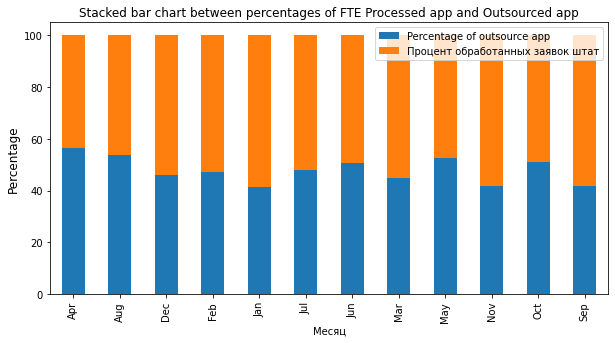

In [ ]:
#Creating bar chart to show percentage of FTE and Outsourced application
df = Output_actual[['Месяц', 'Спрос', 'Колво аутсорсных заявок','Кол-во обработанных заявок']].groupby(['Месяц']).sum()
df['Процент_заявок_на_аутсорс'] = df['Колво аутсорсных заявок']/df['Спрос']*100
df['Процент обработанных заявок штат'] = df['Кол-во обработанных заявок']/df['Спрос']*100
ax = df[['Процент_заявок_на_аутсорс','Процент обработанных заявок штат']].plot(kind='bar', stacked=True, figsize=(10,5))
ax.set_ylabel("Процент", fontsize=12)
plt.title("Гистограмма соотношение доли обработанных заявок штатом и аутсорсом", fontsize=12)
plt.show()

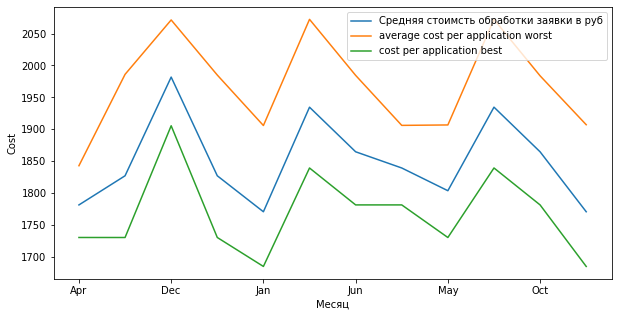

In [ ]:
#Creating the chart to show cost per application in every case
df_new = pd.concat([Output_actual[['Средняя стоимсть обработки заявки в руб','Месяц']], Output_worst['average cost per application worst'], Output_best['cost per application best']], axis=1)
df_new = df_new.groupby(['Месяц']).mean()
df_new.plot.line(figsize=[10,5])
plt.xlabel("Месяц")
plt.ylabel("Стоимость")
plt.show()
